In [1]:
import collections
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20230831_HEK_H3K4me3_scChIPseq')
DIR_REF = os.path.join(DIR_PROJECT, 'data_ref')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20230831_HEK_H3K4me3_scChIPseq')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20230831_HEK_H3K4me3_scChIPseq')
os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_REF, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)

# Download reference data

ENCODE HEK H3K4me3 Peaks - see [ENCODE experiment ENCSR000DTU](https://www.encodeproject.org/experiments/ENCSR000DTU/)
- Replicated peaks: ENCFF297UMP = Bed file, ENCFF798XQI = bigBed file (same information, just different file format)

In [3]:
%%bash -s {DIR_REF}
DIR_REF="$1"
cd "$DIR_REF"
if [ ! -f "ENCODE_HEK_H3K4me3.bed" ]; then
    URL_ENCODE_HEK_H3K4ME3='https://www.encodeproject.org/files/ENCFF297UMP/@@download/ENCFF297UMP.bed.gz'
    wget -q -O "ENCODE_HEK_H3K4me3.bed.gz" "$URL_ENCODE_HEK_H3K4ME3"
    zcat "ENCODE_HEK_H3K4me3.bed.gz" |
        sort -k1,1V -k2,2g -k3,3g > "ENCODE_HEK_H3K4me3.bed"
    rm "ENCODE_HEK_H3K4me3.bed.gz"
fi

In [4]:
path_ENCODE_HEK_H3K4me3 = os.path.join(DIR_REF, 'ENCODE_HEK_H3K4me3.bed')

Count total number of bases covered by ENCODE HEK H3K4me3 peaks

In [5]:
%%bash -s {path_ENCODE_HEK_H3K4me3}
path_ENCODE_HEK_H3K4me3="$1"
source ~/.bashrc
conda activate chipdip
bedtools merge -i "$path_ENCODE_HEK_H3K4me3" | awk -F'\t' 'BEGIN{SUM=0} {SUM += $3-$2} END {print SUM}'

29078674


Compare with GRCh38 genome size: 3,088,269,832 bp of placed scaffolds

In [6]:
29078674 / 3088269832

0.00941584627699721

# Sequencing QC

Read lengths: R1 = 101 bp, R2 = 201 bp

Merge aliquots

In [8]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
if [ ! -f "${DIR_PROC}/R1.fastq.gz" ] || [ ! -f "${DIR_PROC}/R2.fastq.gz" ]; then
    unpigz -c "$DIR_DATA"/*R1_001.fastq.gz | pigz -p 8 > "${DIR_PROC}/R1.fastq.gz"
    unpigz -c "$DIR_DATA"/*R2_001.fastq.gz | pigz -p 8 > "${DIR_PROC}/R2.fastq.gz"
fi

Number of total paired reads

In [9]:
%%bash -s {DIR_DATA}
DIR_DATA="$1"
cd "$DIR_DATA"
unpigz -c *R1_001.fastq.gz | wc -l | awk '{print $1/4}'

7320179


In [192]:
%%bash -s {DIR_DATA} {DIR_AUX}
DIR_DATA="$1"
DIR_AUX="$2"
source ~/.bashrc
conda activate chipdip
DIR_FASTQC_OUT="$DIR_AUX/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_AUX/fastqc"
fi
cd "$DIR_DATA"
fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"

application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip


# Read structure analysis

Barcode structure: Oligo + R1-R3 + NYLigOdd + DPM + Odd + Even + Odd + Even + NYLigEven

Sizes (total difference of 7 nt difference between min and max: 2 terminal tags + Oligo ID)
- Oligo ID: 9-10 nt
- UMI: 8 nt
- R1-R3 unique: 16 nt
- Odd/Even unique: 17 nt
- DPM unique: 9 nt
- DPM Bot: 33 nt
- NYStgBot: 31-34 nt
- NYLigOdd/EvenStg unique: 9-12 nt
- Odd/Even/R1-R3 overhang: 7 nt
- Barcode length: add 52 nt
  - 30 nt for oligo 3' end + 22 nt for NYStgBot 5' end
- Barcode length, DPMTop: add 51 nt
  - 30 nt for oligo 3' end + 21 nt for DPMTop 3' end
- PCR length, 2Puni + 2Pbc: add 136 nt
  - 2Puni (69 nt) + 2Pbc (66 nt) + 1 nt (because 2Puni misses 1 nt from Illumina multiplexing read 1 primer)
- PCR length, 2Puni + 2Puni: add 140 nt

Expected read structures
- Oligo, full (read length: 262-269 bp, barcode length: 314-321 bp, PCR length: 398-405 bp) [[Benchling](https://benchling.com/s/seq-k7mxBE3eUhg4N7XV5WC3)]
  - R1: oligo barcode (rc) + UMI (rc) + R1 + R2 + R3 + Y + DPM + Odd + Even + Odd + Even + Y
  - R2: Y_bot + Even_bot + Odd_bot + Even_bot + Odd_bot + DPM_bot + Y_bot + R3_bot + R2_bot + R1_bot + UMI + oligo barcode
- Oligo, short (read length: 102-106 bp, barcode length: 154-168 bp, PCR length: 238-242 bp) [[Benchling](https://benchling.com/s/seq-T9t12cM5vSMuNkk1PUH1)]
  - R1: oligo barcode (rc) + UMI (rc) + R1 + R2 + R3 + Y
  - R2: Y_bot + R3_bot + R2_bot + R1_bot + UMI + oligo barcode
- Oligo, short (DPM top) (read length: 134-138 bp, barcode length: 185-189 bp, PCR length: 274-278 bp) [[Benchling](https://benchling.com/s/seq-YQ37AIh0UOMtjQ0MwhdE)]
  - R1 (1): oligo barcode (rc) + UMI (rc) + R1 + R2 + R3 + Y + DPM top
  - R1 (2): DPM_bot + Y_bot + R3_bot + R2_bot + R1_bot + UMI (rc) + oligo barcode (rc)
  - R2: n/a
- Oligo, cluster only (read length: 129-133 bp, barcode length: 181-185 bp, PCR length: 265-268 bp) [[Benchling](https://benchling.com/s/seq-jUgAj6D6IiIv4XCJvHI1)]
  - R1: oligo barcode (rc) + UMI (rc) + Odd + Even + Odd + Even + Y
  - R2: Y_bot + Even_bot + Odd_bot + Even_bot + Odd_bot + UMI + oligo barcode
- Chromatin
  - R1: DPM_bot + DNA + A + DPM + Odd + Even + Odd + Even + Y
  - R2: Y_bot + Even_bot + Odd_bot + Even_bot + Odd_bot + DPM_bot + DNA + DPM

Unexpected dominant read structures
- DPM dimer, cluster only (read length: 147-150 bp, PCR length: 283-286 bp)
  - R1: DPMBot + DPMTop + OddTop + EvenTop
  - R2: Y_bot + EvenBot + OddBot + EvenBot + OddBot + DPMBot + DPMTop

| Structure                       | Count   | Proportion of total | Proportion of parent |
| ------------------------------- | ------- | ------------------- | -------------------- |
| `Total`                         | 7320179 | 100%                | n/a                  |
| `Oligo` at start of read 1      | 1329579 | 18.16%              | 18.16%               |
| `- Oligo, short`                | 314846  | 4.3%                | 23.68%               |
| `- Oligo, full`                 | 792     | 0.01%               | 0.06%                |
| `- Oligo, cluster only`         | 274254  | 3.75%               | 20.63%               |
| `- Oligo, short (DPM top)`      | ~0      | ~0%                 | ~0%                  |
| `DPM`                           | 5542531 | 75.72%              | 75.72%               |
| `- Chromatin, putative`         | 185019  | 2.53%               | 3.34%                |
| `  - Chromatin, aligned`        | 83925   | 1.15%               | 45.36%               |
| `    - Chromatin, H3K4me3 peak` | 4332    | 0.06%               | 5.16%                |
| `- DPM dimer, cluster only`     | 2139174 | 29.22%              | 38.60%               |

## Detect all technical sequences

At least 1 technical sequence is present in essentially all reads

In [11]:
%%bash -s {DIR_PROC} {DIR_AUX}
DIR_PROC="$1"
DIR_AUX="$2"

PATH_R1="${DIR_PROC}/R1.fastq.gz"
PATH_R2="${DIR_PROC}/R2.fastq.gz"
PATH_CONFIG="${DIR_AUX}/splitcode_config-all_short.tsv"
PATH_MAPPING="${DIR_AUX}/mapping-all_short.tsv"
PATH_SUMMARY="${DIR_AUX}/summary-all_short.json"
PATH_OUTPUT1="${DIR_PROC}/out_R1-all_short.fastq.gz"
PATH_OUTPUT2="${DIR_PROC}/out_R2-all_short.fastq.gz"

splitcode -c "$PATH_CONFIG" \
    --assign --no-outb --loc-names --nFastqs=2 --gzip --compress 6 -t 8 \
    --output="${PATH_OUTPUT1},${PATH_OUTPUT2}" --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
    "$PATH_R1" "$PATH_R2"

* Using a list of 1017 tags (vector size: 2030; map size: 1,156,025; num elements in map: 1,300,305)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20230831_HEK_H3K4me3_scChIPseq/R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data_proc/20230831_HEK_H3K4me3_scChIPseq/R2.fastq.gz
* processing the reads ...
done 
* processed 7,320,179 reads, 7,318,991 reads were assigned


Order of tags output by splitcode: read 1, then read 2, from left to right

In [12]:
%%bash -s {DIR_AUX}
DIR_AUX="$1"
PATH_MAPPING="${DIR_AUX}/mapping-all_short.tsv"
cut -f 2,3 "$PATH_MAPPING" | sort -r -n -k 2 | column -t -s $'\t' | head

DPMBot6_21,DPMTop6_63,OddTop_9,EvenTop_34,NYStgBot_8,EvenBot_72,OddBot_42,EvenBot_34,OddBot_9,DPMBot6_63,DPMTop6_21                                              408188
DPMBot6_21,DPMTop6_63,OddTop_9,EvenTop_34,NYStgBot_8,EvenBot_72,OddBot_42,EvenBot_34,OddBot_9,DPMBot6_63,DPMTop6_21,DPMBot6_1                                    62428
DPMBot6_21,DPMTop6_63,OddTop_42,EvenTop_72,NYLigEvenStgTop_8,NYStgBot_8,EvenBot_72,OddBot_42,DPMBot6_63,DPMTop6_21                                               44506
DPMBot6_14,DPMTop6_74,OddTop_18,EvenTop_33,NYStgBot_35,EvenBot_46,OddBot_37,EvenBot_33,OddBot_18,DPMBot6_74,DPMTop6_14                                           38239
DPMBot6_21,DPMTop6_63,NYLigEvenStgTop_8,adapter,NYStgBot_8,DPMBot6_63,DPMTop6_21                                                                                 35855
DPMBot6_22,DPMTop6_75,OddTop_21,EvenTop_31,NYStgBot_20,EvenBot_38,OddBot_72,EvenBot_31,OddBot_21,DPMBot6_75,DPMTop6_22                                           324

In [13]:
%%bash -s {DIR_PROC} {DIR_AUX}
DIR_PROC="$1"
DIR_AUX="$2"
PATH_OUTPUT="${DIR_PROC}/out_R1-all_short.fastq.gz"
PATH_MAPPING_LOC="${DIR_AUX}/mapping_loc-all_short.tsv"

unpigz -c "$PATH_OUTPUT" |
    grep -o -E -e 'LX:Z:.*' | 
    sed -e 's/LX:Z://' |
    sort |
    uniq -c |
    sort -n -r -k1 |
    sed -E -e 's/^\s+//' -e 's/\s+/\t/' > "$PATH_MAPPING_LOC"

Terminology
- `loc`: locations given in format `<file #>,<start>-<end>`
- `order`: no locations
- `R1`: only tags found in read 1; locations (if present) are simplified to `<start>-<end>`
- `R2`: only tags found in read 2; locations (if present) are simplified to `<start>-<end>`
- `group`: tag names are reduced to their group (e.g., `DPMBot6` instead of `DPMBot6_22`)

In [14]:
df = pd.read_csv(os.path.join(DIR_AUX, 'mapping_loc-all_short.tsv'), sep='\t', header=None, names=['count', 'pattern_loc'])

In [15]:
df['pattern_loc_group'] = df['pattern_loc'].str.replace('_\d+:', ':', regex=True)
df['pattern_order'] = df['pattern_loc'].str.replace(':\d+,\d+-\d+', '', regex=True)
df['pattern_order_group'] = df['pattern_order'].str.replace('_(\d+|bc\d+)', '', regex=True)
df['pattern_loc_R1'] = df['pattern_loc'].str.extract('(([^,:]+:0,\d+-\d+,?)+)', expand=False)[0].str.replace(':0,', ':').str.rstrip(',')
df['pattern_loc_R2'] = df['pattern_loc'].str.extract('(([^,:]+:1,\d+-\d+,?)+)', expand=False)[0].str.replace(':1,', ':').str.rstrip(',')
df['pattern_loc_group_R1'] = df['pattern_loc_R1'].str.replace('_(\d+|bc\d+)', '', regex=True)
df['pattern_loc_group_R2'] = df['pattern_loc_R2'].str.replace('_(\d+|bc\d+)', '', regex=True)
df['pattern_order_R1'] = df['pattern_loc_R1'].str.replace(':\d+-\d+', '', regex=True).str.rstrip(',')
df['pattern_order_R2'] = df['pattern_loc_R2'].str.replace(':\d+-\d+', '', regex=True).str.rstrip(',')
df['pattern_order_group_R1'] = df['pattern_order_R1'].str.replace('_(\d+|bc\d+)', '', regex=True)
df['pattern_order_group_R2'] = df['pattern_order_R2'].str.replace('_(\d+|bc\d+)', '', regex=True)

In [16]:
mask_R1_NA = df['pattern_loc_R1'].isna()
mask_R2_NA = df['pattern_loc_R2'].isna()
assert (mask_R1_NA & mask_R2_NA).sum() == 0

In [17]:
print('Number of R1 reads without detected tags:', df.loc[mask_R1_NA, 'count'].sum())
print('Number of R2 reads without detected tags:', df.loc[mask_R2_NA, 'count'].sum())

Number of R1 reads without detected tags: 8045
Number of R2 reads without detected tags: 30759


In [18]:
# convenient views into the data; for read only, not to modify
df_R1_tagged = df.loc[~mask_R1_NA]
df_R2_tagged = df.loc[~mask_R2_NA]
df_pair_tagged = df.loc[~(mask_R1_NA | mask_R2_NA)]

### Read 1

Most common tag groups, with location

In [19]:
df_R1_tagged.groupby('pattern_loc_group_R1')['count'].sum().sort_values(ascending=False).head(10)

pattern_loc_group_R1
DPMBot6:0-9,DPMTop6:10-30,OddTop:35-59,EvenTop:59-83                           2903137
DPMBot6:0-9,DPMTop6:10-30,OddTop:35-59,EvenTop:59-83,NYLigEvenStgTop:83-100     333745
DPMBot6:0-9,EvenTop:26-50,OddTop:50-74,EvenTop:74-98                            294247
DPMBot6:0-9,DPMTop6:10-30,OddTop:35-59,EvenTop:59-83,NYLigEvenStgTop:83-99      282688
OligoRC:0-9,OddTop:17-41,EvenTop:41-65,OddTop:65-89                             209451
OligoRC:0-10,R1Top:18-41,R2Top:41-64,R3Top:64-87                                193389
OligoRC:0-9,R1Top:17-40,R2Top:40-63,R3Top:63-86                                 181516
DPMBot6:0-9,DPMTop6:10-30,NYLigEvenStgTop:35-52,adapter:52-65                   158670
DPMBot6:0-9,DPMTop6:10-30,NYLigEvenStgTop:35-51,adapter:51-64                   153559
DPMBot6:0-9,NYLigEvenStgTop:26-43,adapter:43-56                                 143143
Name: count, dtype: int64

Most common tag orders

In [20]:
df_R1_tagged.groupby('pattern_order_group_R1')['count'].sum().sort_values(ascending=False).head(10)

pattern_order_group_R1
DPMBot6,DPMTop6,OddTop,EvenTop                    3011410
DPMBot6,DPMTop6,OddTop,EvenTop,NYLigEvenStgTop     638682
OligoRC,R1Top,R2Top,R3Top                          404643
OligoRC,OddTop,EvenTop,OddTop                      342870
DPMBot6,DPMTop6,NYLigEvenStgTop,adapter            321300
DPMBot6,EvenTop,OddTop,EvenTop                     307938
DPMBot6,NYLigEvenStgTop,adapter                    276525
DPMBot6,EvenTop,NYLigEvenStgTop,adapter            201581
DPMBot6,OddTop,EvenTop,NYLigEvenStgTop             188579
DPMBot6                                            103905
Name: count, dtype: int64

Most common starting tags

In [21]:
df_R1_tagged.assign(first_tag=df_R1_tagged['pattern_loc_R1'].map(lambda s: s.split(',')[0])) \
    .groupby('first_tag')['count'].sum().sort_values(ascending=False).head(10)

first_tag
DPMBot6_22:0-9      1615665
DPMBot6_21:0-9      1185360
DPMBot6_14:0-9       543132
DPMBot6_18:0-9       509146
DPMBot6_1:0-9        503471
OligoRC_bc4:0-9      436226
OligoRC_bc5:0-10     321600
OligoRC_bc3:0-9      298597
OligoRC_bc2:0-10     273156
DPMBot6_44:0-9       272743
Name: count, dtype: int64

In [22]:
df_R1_tagged.assign(first_tag_group=df_R1_tagged['pattern_loc_group_R1'].map(lambda s: s.split(',')[0])) \
    .groupby('first_tag_group')['count'].sum().sort_values(ascending=False).head(10)

first_tag_group
DPMBot6:0-9      5542531
OligoRC:0-9       734823
OligoRC:0-10      594756
DPMTop6:9-29       56494
DPMTop6:10-30      23923
DPMTop6:1-21       22111
OddTop:25-49       17290
NYStgBot:0-10      16740
OddTop:17-41       13778
NYStgBot:0-9       13754
Name: count, dtype: int64

### Read 2

Most common tag groups, with location

In [23]:
df_R2_tagged.groupby('pattern_loc_group_R2')['count'].sum().sort_values(ascending=False).head(10)

pattern_loc_group_R2
NYStgBot:0-9,EvenBot:9-33,OddBot:33-57,EvenBot:57-81,OddBot:81-105,DPMBot6:128-137,DPMTop6:138-158      969425
NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,EvenBot:58-82,OddBot:82-106,DPMBot6:129-138,DPMTop6:139-159    870475
NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,DPMBot6:81-90,DPMTop6:91-111                                   255477
NYStgBot:0-9,EvenBot:9-33,OddBot:33-57,DPMBot6:80-89,DPMTop6:90-110                                     225525
NYStgBot:0-10,DPMBot6:33-42,DPMTop6:43-63                                                               138243
NYStgBot:0-10,EvenBot:10-34,DPMTop6:34-54                                                               134909
NYStgBot:0-9,DPMBot6:32-41,DPMTop6:42-62                                                                134251
NYStgBot:0-9,EvenBot:9-33,DPMTop6:33-53                                                                 105745
NYStgBot:0-9,EvenBot:9-33,OddBot:33-57,EvenBot:57-81,OddBot:81-105,DPMTop6:105-125         

Most common tag orders

In [24]:
df_R2_tagged.groupby('pattern_order_group_R2')['count'].sum().sort_values(ascending=False).head(10)

pattern_order_group_R2
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6,DPMTop6           2195637
NYStgBot,EvenBot,OddBot,DPMBot6,DPMTop6                           563071
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,Oligo                      355394
NYStgBot,R3Bot,R2Bot,R1Bot,Oligo                                  324364
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMTop6                    294709
NYStgBot,DPMBot6,DPMTop6                                          287336
NYStgBot,EvenBot,DPMTop6                                          264153
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6     212455
NYStgBot,EvenBot,OddBot,DPMTop6                                   207179
NYStgBot,EvenBot,OddBot,EvenBot,DPMTop6                           202840
Name: count, dtype: int64

Most common starting tags

In [25]:
df_R2_tagged.assign(first_tag=df_R2_tagged['pattern_loc_R2'].map(lambda s: s.split(',')[0])) \
    .groupby('first_tag')['count'].sum().sort_values(ascending=False).head(10)

first_tag
NYStgBot_8:0-9      886114
NYStgBot_37:0-10    304219
NYStgBot_19:0-9     246831
NYStgBot_20:0-10    226778
NYStgBot_40:0-9     215228
NYStgBot_41:0-10    214351
NYStgBot_35:0-10    201859
NYStgBot_7:0-10     194757
NYStgBot_10:0-10    194746
NYStgBot_12:0-10    189376
Name: count, dtype: int64

In [26]:
df_R2_tagged.assign(first_tag_group=df_R2_tagged['pattern_loc_group_R2'].map(lambda s: s.split(',')[0])) \
    .groupby('first_tag_group')['count'].sum().sort_values(ascending=False).head(10)

first_tag_group
NYStgBot:0-10    3554530
NYStgBot:0-9     3441929
EvenBot:9-33       55053
NYStgBot:0-12      44473
EvenBot:10-34      41623
DPMTop6:25-45      12402
NYStgBot:0-11      11036
EvenBot:8-32        7606
DPMTop6:26-46       7569
OddBot:34-58        3739
Name: count, dtype: int64

## Oligo reads

Total number of reads containing oligo

In [27]:
print('Total number of oligo-containing reads:', df.loc[df['pattern_order_group'].str.contains('Oligo'), 'count'].sum())

Total number of oligo-containing reads: 1420981


In [28]:
print('Total number of R1 reads starting with OligoRC:', df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.startswith('OligoRC:0-'), 'count'].sum())

Total number of R1 reads starting with OligoRC: 1329579


### Cell barcode oligos (read 1 = oligo + R1-R3)

In [53]:
regex_oligo_r1_r1_loc = r'OligoRC:0-\d+,R1Top'
regex_oligo_cell_r1_loc = r'OligoRC:0-\d+,R1Top:\d+-\d+,R2Top:\d+-\d+,R3Top:\d+-\d+'
regex_oligo_cell_short_r2 = r'^NYStgBot,R3Bot,R2Bot,R1Bot,Oligo$'
regex_oligo_cell_full_r2 = r'^NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6,NYStgBot,R3Bot'

In [54]:
print('Oligo + R1 reads:', df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_r1_r1_loc), 'count'].sum())
print('Oligo + R1-R3 reads:', df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cell_r1_loc), 'count'].sum())
print('Oligo + R1-R3 + Y reads (Oligo, short):',
      df_R1_tagged.loc[
          df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cell_r1_loc) &
          df_R1_tagged['pattern_order_group_R2'].str.contains(regex_oligo_cell_short_r2),
          'count'].sum())
print('Oligo + R1-R3 + Y + DPM + Odd + Even + Odd + Even + Y reads (Oligo, full):',
      df_R1_tagged.loc[
          df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cell_r1_loc) &
          df_R1_tagged['pattern_order_group_R2'].str.contains(regex_oligo_cell_full_r2),
          'count'].sum())

Oligo + R1 reads: 629763
Oligo + R1-R3 reads: 413131
Oligo + R1-R3 + Y reads (Oligo, short): 314846
Oligo + R1-R3 + Y + DPM + Odd + Even + Odd + Even + Y reads (Oligo, full): 792


In [39]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cell_r1_loc)] \
    .groupby('pattern_loc_group_R2')['count'].sum() \
    .sort_values(ascending=False).head(10)

pattern_loc_group_R2
NYStgBot:0-9,R3Bot:9-32,R2Bot:32-55,R1Bot:55-78,Oligo:94-116                                                     69821
NYStgBot:0-9,R3Bot:9-32,R2Bot:32-55,R1Bot:55-78,Oligo:94-115                                                     64138
NYStgBot:0-10,R3Bot:10-33,R2Bot:33-56,R1Bot:56-79,Oligo:95-117                                                   56844
NYStgBot:0-10,R3Bot:10-33,R2Bot:33-56,R1Bot:56-79,Oligo:95-116                                                   51919
NYStgBot:0-12,R3Bot:12-35,R2Bot:35-58,R1Bot:58-81,Oligo:97-119                                                   17582
NYStgBot:0-12,R3Bot:12-35,R2Bot:35-58,R1Bot:58-81,Oligo:97-118                                                   15814
NYStgBot:0-9,R3Bot:9-32,R2Bot:32-55,R1Bot:55-77,Oligo:93-114                                                      2528
NYStgBot:0-9,R3Bot:9-32,R2Bot:32-55,R1Bot:55-77,Oligo:93-115                                                      2525
NYStgBot:0-10,EvenBot:10-34

Other tag orders with R1-R3 cell barcode

In [40]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cell_r1_loc)] \
    .groupby('pattern_order_group_R2')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_order_group_R2
NYStgBot,R3Bot,R2Bot,R1Bot,Oligo                           314846
NYStgBot,EvenBot,OddBot,EvenBot,R3Bot,R2Bot,R1Bot,Oligo     10465
NYStgBot,R3Bot,R2Bot,R1Bot,Oligo,DPMBot6                     9584
NYStgBot,R3Bot,R2Bot,R1Bot,adapter                           9237
R3Bot,R2Bot,R1Bot,Oligo                                      5670
Name: count, dtype: int64

Tag orders with full oligo barcode

In [43]:
df_R1_tagged.loc[
    df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cell_r1_loc) &
    df_R1_tagged['pattern_order_group_R2'].str.contains(regex_oligo_cell_full_r2)] \
    .groupby('pattern_order_group_R2')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_order_group_R2
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6,NYStgBot,R3Bot          608
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6,NYStgBot,R3Bot,R2Bot    184
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6,NYStgBot                 13
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6,NYStgBot,R2Bot            1
Name: count, dtype: int64

How does read 2 extend all the way to R2Bot?
- It seems like the 5' end of NYStgBot is trimmed. Potential explanations include sonication or exonuclease activity during end repair / dA-tailing.

In [45]:
df_R1_tagged.loc[
    df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cell_r1_loc) &
    df_R1_tagged['pattern_order_group_R2'].str.contains(regex_oligo_cell_full_r2) &
    df_R1_tagged['pattern_order_group_R2'].str.contains('R2Bot')] \
    .groupby('pattern_loc_group_R2')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_loc_group_R2
NYStgBot:0-9,EvenBot:9-33,OddBot:33-57,EvenBot:57-81,OddBot:81-105,DPMBot6:128-137,NYStgBot:140-149,R3Bot:149-172,R2Bot:172-195      12
NYStgBot:0-9,EvenBot:9-33,OddBot:33-57,EvenBot:57-81,OddBot:81-105,DPMBot6:128-137,NYStgBot:138-148,R3Bot:148-171,R2Bot:171-194      10
NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,EvenBot:58-82,OddBot:82-106,DPMBot6:129-138,NYStgBot:141-150,R3Bot:150-173,R2Bot:173-196    10
NYStgBot:0-9,EvenBot:9-33,OddBot:33-57,EvenBot:57-81,OddBot:81-105,DPMBot6:128-137,NYStgBot:141-150,R3Bot:150-173,R2Bot:173-196       9
NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,EvenBot:58-82,OddBot:82-106,DPMBot6:129-138,NYStgBot:143-153,R3Bot:153-176,R2Bot:176-199     9
Name: count, dtype: int64

### Cluster barcode oligos (read 1 = oligo + odd + even + odd)

In [55]:
regex_oligo_odd_r1_loc = r'OligoRC:0-\d+,OddTop'
regex_oligo_cluster_r1_loc = r'OligoRC:0-\d+,OddTop:\d+-\d+,EvenTop:\d+-\d+,OddTop:\d+-\d+'
regex_oligo_cluster_r2 = r'^NYStgBot,EvenBot,OddBot,EvenBot,OddBot,Oligo$'

In [56]:
print('Oligo + Odd reads:', df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_odd_r1_loc), 'count'].sum())
print('Oligo + Odd + Even + Odd R1 reads:', df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cluster_r1_loc), 'count'].sum())
print('Oligo + Odd + Even + Odd + Even + Y reads (Oligo, cluster only):',
      df_R1_tagged.loc[
          df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cluster_r1_loc) &
          df_R1_tagged['pattern_order_group_R2'].str.contains(regex_oligo_cluster_r2),
          'count'].sum())

Oligo + Odd reads: 476101
Oligo + Odd + Even + Odd R1 reads: 342796
Oligo + Odd + Even + Odd + Even + Y reads (Oligo, cluster only): 274254


Other tag orders with Oligo + Odd + Even + Odd cluster barcode

In [59]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_cluster_r1_loc)] \
    .groupby('pattern_order_group_R2')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_order_group_R2
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,Oligo                   274254
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,EvenBot,OddBot,Oligo     13663
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,adapter                   9889
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,Oligo,DPMBot6             7349
NYStgBot,EvenBot,OddBot,OddBot,EvenBot,OddBot,Oligo              4274
Name: count, dtype: int64

### Other Oligos

The most common tag order for oligos not ligated by R1 or Odd is directly to NYLigEven.

In [60]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains('OligoRC:0-\d+,(?!OddTop|R1Top)')] \
    .groupby('pattern_loc_group_R1')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_loc_group_R1
OligoRC:0-9,DPMTop6:25-45,OddTop:50-74,EvenTop:74-98     6433
OligoRC:0-9,EvenTop:36-60,OddTop:60-84                   6410
OligoRC:0-10,EvenTop:37-61,OddTop:61-85                  4271
OligoRC:0-9,NYLigEvenStgTop:17-34,adapter:34-47          3909
OligoRC:0-10,DPMTop6:26-46,OddTop:51-75,EvenTop:75-99    3797
Name: count, dtype: int64

In [61]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains('OligoRC:0-\d+,(?!OddTop|R1Top)')] \
    .groupby('pattern_order_group_R1')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_order_group_R1
OligoRC,EvenTop,OddTop                     46131
OligoRC,NYLigEvenStgTop,adapter            41400
OligoRC,DPMTop6,OddTop,EvenTop             32511
OligoRC,EvenTop,NYLigEvenStgTop,adapter    27213
OligoRC,EvenTop,OddTop,EvenTop             17820
Name: count, dtype: int64

#### Oligo, short (DPM top)

Conclusion: not a major product

Expected structure:

- R1 (1): oligo barcode (rc) + UMI (rc) + R1 + R2 + R3 + Y + DPM top
  - Cannot observe with R1 read length of only 100- 
R1 (2): DPM_bot + Y_bot + R3_bot + R2_bot + R1_bot + UMI (rc) + oligo barcode (rc)

In [62]:
df_R1_tagged.loc[
    df_R1_tagged['pattern_loc_group_R1'].str.contains(regex_oligo_r1_r1_loc) &
    df_R1_tagged['pattern_order_group_R1'].str.contains('DPMTop6')] \
    .groupby('pattern_order_group_R1')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_order_group_R1
OligoRC,R1Top,DPMTop6,OddTop                     18772
OligoRC,R1Top,DPMTop6                             4638
OligoRC,R1Top,R2Top,DPMTop6                       3573
OligoRC,R1Top,DPMTop6,NYLigEvenStgTop              451
OligoRC,R1Top,DPMTop6,NYLigEvenStgTop,adapter      406
Name: count, dtype: int64

No (or almost no) R1 reads have `DPM_bot + Y_bot + R3_bot` structure

In [63]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains('^DPMBot6:[0-9]-\d+,NYStgBot'), 'count'].sum()

13111

In [64]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains('^DPMBot6:[0-9]-\d+,NYStgBot')] \
    .groupby('pattern_order_group_R1')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_order_group_R1
DPMBot6,NYStgBot,OddTop,EvenTop             4438
DPMBot6,NYStgBot,EvenTop,NYLigEvenStgTop    3997
DPMBot6,NYStgBot                            1026
DPMBot6,NYStgBot,adapter                     891
DPMBot6,NYStgBot,EvenTop,OddTop              719
Name: count, dtype: int64

Just in case, check R2 for such structures. Practically no R2 reads start with DPMBot6.

In [65]:
df_R2_tagged.loc[df_R2_tagged['pattern_order_group_R2'].str.startswith('DPMBot6'), 'count'].sum()

10576

In [66]:
df_R2_tagged.loc[df_R2_tagged['pattern_order_group_R2'].str.startswith('DPMBot6')] \
    .groupby('pattern_order_group_R2')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_order_group_R2
DPMBot6,DPMTop6            5144
DPMBot6                    2108
DPMBot6,adapter             995
DPMBot6,DPMBot6,adapter     418
DPMBot6,DPMTop6,DPMBot6     233
Name: count, dtype: int64

## DPM Reads

Most R1 reads start with DPMBot. Most of the remaining reads start with oligo_rc

In [71]:
print('R1 reads starting with DPMBot: {} ({:.2%})'.format(
    df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.startswith('DPMBot6:0-'), 'count'].sum(),
    df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.startswith('DPMBot6:0-'), 'count'].sum() / df['count'].sum()))

R1 reads starting with DPMBot: 5542531 (75.73%)


In [72]:
print('R1 reads starting with oligo_rc: {} ({:.2%})'.format(
    df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.startswith('OligoRC:0-'), 'count'].sum(),
    df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.startswith('OligoRC:0-'), 'count'].sum() / df['count'].sum()))

R1 reads starting with oligo_rc: 1329579 (18.17%)


### DPM Dimer + Cluster Barcode

In [115]:
df_pair_tagged.loc[
    df_pair_tagged['pattern_loc_group_R1'].str.startswith('DPMBot6:0-') &
    df_pair_tagged['pattern_order_group_R1'].str.startswith('DPMBot6,DPMTop6,OddTop,EvenTop') &
    df_pair_tagged['pattern_order_group_R2'].str.match('^NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6,DPMTop6$')] \
    .groupby('pattern_order_group_R2')['count'].sum() \
    .sort_values(ascending=False).head()

pattern_order_group_R2
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot6,DPMTop6    2139174
Name: count, dtype: int64

### DPMBot with or without dT

- The vast majority of R1 reads starting with DPMBot have do not have the dT overhang at the 3' end of DPMBot.
  - This suggests that only DPMBot is not really there; only DPMTop is.
  - Most of these reads have the DPMBot unique sequence followed by an A, suggesting dA-tailing. (This is presumably how DPMTop subsequently gets ligated on.) Therefore, it seems as if these molecules don't actually have DPMBot, but rather some sequence to which DPMTop is complementary.
- However, most R1 reads that only contain (and start with) DPMBot have the dT overhang, suggesting that these correspond to expected dA-tailed chromatin DNA.

In [87]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_OUTPUT="${DIR_PROC}/out_R1-all_short.fastq.gz"

unpigz -c "$PATH_OUTPUT" |
    awk -v pattern='LX:Z:DPMBot[^:]+:0,0-' \
        'BEGIN{RS="@"; FS="\n"} $1 ~ pattern {printf "@%s\t%s\n", $1, substr($2, 10, 1)}' |
    sed -E -e 's/^@\S+\sLX:Z://' -e 's/:0,/:/g' -e 's/[^,:]+:1\S+//' -e 's/_([0-9]+|bc[0-9]):/:/g' -e 's/,\t/\t/' |
    sort |
    uniq -c |
    sed -E -e 's/^\s+//' -e 's/\s+/\t/' |
    sort -n -r -k1 -k2 |
    column -t -s $'\t' | 
    head -n 20

4160161  DPMBot6:0-9                                                                               A
294143   DPMBot6:0-9,EvenTop:26-50,OddTop:50-74,EvenTop:74-98                                      A
148586   DPMBot6:0-9                                                                               T
143109   DPMBot6:0-9,NYLigEvenStgTop:26-43,adapter:43-56                                           A
113085   DPMBot6:0-9,NYLigEvenStgTop:26-42,adapter:42-55                                           A
99128    DPMBot6:0-9,OddTop:26-50,EvenTop:50-74,NYLigEvenStgTop:74-91                              A
98763    DPMBot6:0-9,EvenTop:26-50,NYLigEvenStgTop:50-67,adapter:67-80                             A
90129    DPMBot6:0-9,EvenTop:26-50,NYLigEvenStgTop:50-66,adapter:66-79                             A
83831    DPMBot6:0-9,OddTop:26-50,EvenTop:50-74,NYLigEvenStgTop:74-90                              A
31255    DPMBot6:0-9,OddTop:26-50,EvenTop:50-74,OddTop:74-98                               

In [76]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_OUTPUT="${DIR_PROC}/out_R1-all_short.fastq.gz"

unpigz -c "$PATH_OUTPUT" |
    awk -v pattern='LX:Z:DPMBot[^:]+:0,0-' \
        'BEGIN{RS="@"; FS="\n"} $1 ~ pattern {print substr($2, 10, 1)}' |
    sort | uniq -c |
    sort -n -r

5270846 A
 219906 T
  26340 C
  25439 G


### Chromatin Reads

#### Insert length < R1 length: DPMBot + insert + DPMTop
Reads with DPMBot + insert (>= 11 bp) + DPMTop

In [80]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.extract('^DPMBot6:0-\d+,DPMTop6:(\d+)', expand=False).astype(float) >= 20, 'count'].sum()

4742

Trimming: Remove 5' DPMBot and 3' DPMTop (`DPM_bot + DNA + A + DPM + ...` --> `DNA`)

In [82]:
%%bash -s {DIR_PROC} {DIR_AUX}
DIR_PROC="$1"
DIR_AUX="$2"

CONFIG_NAME="R1_3prime_DPM_trim"

PATH_CONFIG="${DIR_AUX}/splitcode_config-${CONFIG_NAME}.tsv"
PATH_MAPPING="${DIR_AUX}/mapping-${CONFIG_NAME}.tsv"
PATH_SUMMARY="${DIR_AUX}/summary-${CONFIG_NAME}.json"
PATH_OUTPUT="${DIR_PROC}/out_R1-all_short.fastq.gz"
PATH_OUTPUT_TRIMMED="${DIR_PROC}/out_${CONFIG_NAME}.fastq.gz"

unpigz -c "$PATH_OUTPUT" |
    awk -v pattern='LX:Z:DPMBot[^:]+:0,0-[0-9]+,DPMTop[^:]+:0,([0-9]+)' \
        'BEGIN{RS="@"; FS="\n"} $1 ~ pattern { match($1, pattern, arr); if (arr[1] >= 20) {printf "@%s\n%s\n+\n%s\n", $1, $2, $4}}' |
    splitcode -c "$PATH_CONFIG" \
        --assign --no-outb --empty-remove --mod-names --gzip --compress 6 -t 4 \
        --output "$PATH_OUTPUT_TRIMMED" --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
        -

* Using a list of 192 tags (vector size: 288; map size: 2,061,476; num elements in map: 2,129,871)
* will process sample 1: -
* processing the reads ...
done 
* processed 4,742 reads, 4,742 reads were assigned


Mapping with Bowtie2

In [184]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

source ~/.bashrc
conda activate chipdip

PATH_OUTPUT_TRIMMED="${DIR_PROC}/out_R1_3prime_DPM_trim.fastq.gz"
PATH_MAPPED_CHROMATIN="${DIR_PROC}/out_R1_3prime_DPM_trim.bam"
PATH_BOWTIE2_INDEX="/central/groups/guttman/genomes/homo_sapiens/hg38/GRCh38_noalt_as/GRCh38_noalt_as"

bowtie2 -p 10 -t --phred33 \
    -x "$PATH_BOWTIE2_INDEX" \
    -U "$PATH_OUTPUT_TRIMMED" |
samtools view -h -F 4 -F 256 -b -q 10 - |
samtools sort > "$PATH_MAPPED_CHROMATIN"
samtools index "$PATH_MAPPED_CHROMATIN"

Time loading reference: 00:00:01
Time loading forward index: 00:00:01
Time loading mirror index: 00:00:00
Multiseed full-index search: 00:00:01
4742 reads; of these:
  4742 (100.00%) were unpaired; of these:
    1812 (38.21%) aligned 0 times
    1724 (36.36%) aligned exactly 1 time
    1206 (25.43%) aligned >1 times
61.79% overall alignment rate
Time searching: 00:00:03
Overall time: 00:00:03


In [185]:
%%bash -s {DIR_PROC} {path_ENCODE_HEK_H3K4me3}
DIR_PROC="$1"
path_ENCODE_HEK_H3K4me3="$2"

source ~/.bashrc
conda activate chipdip

PATH_MAPPED_CHROMATIN="${DIR_PROC}/out_R1_3prime_DPM_trim.bam"

echo "Mapped reads:" $(samtools view -c "$PATH_MAPPED_CHROMATIN")
# samtools -L <FILE>: Only output alignments overlapping the input BED FILE.
echo "Mapped reads (primary alignment)s overlapping known HEK H3K4me3 peaks:" \
    "$(samtools view -c -L "$path_ENCODE_HEK_H3K4me3" "$PATH_MAPPED_CHROMATIN")"

Mapped reads: 2085
Mapped reads (primary alignment)s overlapping known HEK H3K4me3 peaks: 50


#### Insert length > R1 length
Reads with no technical sequences in R1 other than DPMBot
- Unclear if detected Illumina adapters are actually adapters (versus false positives), because we would expect to see `DPMTop`, etc., before we get all the way to the Illumina adapter.

In [85]:
df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains('^DPMBot6:0-\d+(,adapter:\d+-\d+)?$')] \
    .groupby('pattern_order_group_R1')['count'].sum()

/tmp/ipykernel_113798/1231155170.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains('^DPMBot6:0-\d+(,adapter:\d+-\d+)?$')] \


pattern_order_group_R1
DPMBot6            103532
DPMBot6,adapter     76745
Name: count, dtype: int64

Trimming: Remove 5' DPMBot (do not trim any putative 3' Illumina adapter)

In [89]:
%%bash -s {DIR_PROC} {DIR_AUX}
DIR_PROC="$1"
DIR_AUX="$2"

source ~/.bashrc
conda activate chipdip

CONFIG_NAME="R1_DPM_trim"

PATH_CONFIG="${DIR_AUX}/splitcode_config-${CONFIG_NAME}.tsv"
PATH_MAPPING="${DIR_AUX}/mapping-${CONFIG_NAME}.tsv"
PATH_SUMMARY="${DIR_AUX}/summary-${CONFIG_NAME}.json"
PATH_OUTPUT="${DIR_PROC}/out_R1-all_short.fastq.gz"
PATH_OUTPUT_TRIMMED="${DIR_PROC}/out_${CONFIG_NAME}.fastq.gz"

unpigz -c "$PATH_OUTPUT" |
    sed -E -e 's/,[^,:]+:1\S+//' | 
    awk -v pattern='LX:Z:DPMBot[^:]+:0,0-[0-9]+(,adapter:[^:]+)?$' \
        'BEGIN{RS="@"; FS="\n"} $1 ~ pattern {printf "@%s\n%s\n+\n%s\n", $1, $2, $4}' |
    splitcode -c "$PATH_CONFIG" \
        --assign --no-outb --empty-remove --mod-names --gzip --compress 6 -t 4 \
        --output "$PATH_OUTPUT_TRIMMED" --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
        -

* Using a list of 96 tags (vector size: 96; map size: 3,552; num elements in map: 3,552)
* will process sample 1: -
* processing the reads ...
done 
* processed 180,277 reads, 180,277 reads were assigned


Mapping with Bowtie2

In [186]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

source ~/.bashrc
conda activate chipdip

PATH_OUTPUT_TRIMMED="${DIR_PROC}/out_R1_DPM_trim.fastq.gz"
PATH_MAPPED_CHROMATIN="${DIR_PROC}/out_R1_DPM_trim.bam"
PATH_BOWTIE2_INDEX="/central/groups/guttman/genomes/homo_sapiens/hg38/GRCh38_noalt_as/GRCh38_noalt_as"

bowtie2 -p 10 -t --phred33 \
    -x "$PATH_BOWTIE2_INDEX" \
    -U "$PATH_OUTPUT_TRIMMED" |
samtools view -h -F 4 -F 256 -b -q 10 - |
samtools sort > "$PATH_MAPPED_CHROMATIN"
samtools index "$PATH_MAPPED_CHROMATIN"

Time loading reference: 00:00:00
Time loading forward index: 00:00:01
Time loading mirror index: 00:00:01
Multiseed full-index search: 00:00:03
180277 reads; of these:
  180277 (100.00%) were unpaired; of these:
    86875 (48.19%) aligned 0 times
    74662 (41.42%) aligned exactly 1 time
    18740 (10.40%) aligned >1 times
51.81% overall alignment rate
Time searching: 00:00:05
Overall time: 00:00:05


In [187]:
%%bash -s {DIR_PROC} {path_ENCODE_HEK_H3K4me3}
DIR_PROC="$1"
path_ENCODE_HEK_H3K4me3="$2"

source ~/.bashrc
conda activate chipdip

PATH_MAPPED_CHROMATIN="${DIR_PROC}/out_R1_DPM_trim.bam"

echo "Mapped reads:" $(samtools view -c "$PATH_MAPPED_CHROMATIN")
# samtools -L <FILE>: Only output alignments overlapping the input BED FILE.
echo "Mapped reads (primary alignment)s overlapping known HEK H3K4me3 peaks:" \
    "$(samtools view -c -L "$path_ENCODE_HEK_H3K4me3" "$PATH_MAPPED_CHROMATIN")"

Mapped reads: 81840
Mapped reads (primary alignment)s overlapping known HEK H3K4me3 peaks: 4282


# Barcode Statistics

## Cell barcodes

Note: No need to account for the aliquot as a round of split-pool, which only matters for the cluster barcode, but not cell barcode.

In [125]:
%%bash -s {DIR_PROC} {DIR_AUX}
DIR_PROC="$1"
DIR_AUX="$2"

CONFIG_NAME="oligo_cell_barcode_short"

PATH_R1="${DIR_PROC}/R1.fastq.gz"
PATH_R2="${DIR_PROC}/R2.fastq.gz"
PATH_CONFIG="${DIR_AUX}/splitcode_config-${CONFIG_NAME}.tsv"
PATH_MAPPING="${DIR_AUX}/mapping-${CONFIG_NAME}.tsv"
PATH_SUMMARY="${DIR_AUX}/summary-${CONFIG_NAME}.json"
PATH_OUTPUT="${DIR_PROC}/read_names-${CONFIG_NAME}.txt"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 4 \
    --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
    --select=0 --pipe "$PATH_R1" "$PATH_R2" |
    awk '$1 ~ /^>/' > "$PATH_OUTPUT"

In [28]:
regex_oligo_cell_barcode = re.compile((
    r'\[OligoRC_(?P<R1_oligo>bc\d)\]'
    r'\[R1Top_(?P<R1_R1>\d+)\]'
    r'\[R2Top_(?P<R1_R2>\d+)\]'
    r'\[R3Top_(?P<R1_R3>\d+)\]'
    r'(?P<barcode>'
    r'\[NYStgBot_(?P<R2_Y>\d+)\]'
    r'\[R3Bot_(?P<R2_R3>\d+)\]'
    r'\[R2Bot_(?P<R2_R2>\d+)\]'
    r'\[R1Bot_(?P<R2_R1>\d+)\])'
    r'\[Oligo_(?P<R2_oligo>bc\d)\]'))
regex_umi = re.compile(r'RX:Z:([ATCG]+)')

In [29]:
cells = dict()
path_cell_barcodes = os.path.join(DIR_PROC, 'read_names-oligo_cell_barcode_short.txt')
with open(path_cell_barcodes) as f:
    for name in f:
        name = name.strip()
        match = regex_oligo_cell_barcode.search(name)
        if match:
            tags = match.groupdict()
            if (tags['R1_oligo'] != tags['R2_oligo']) or \
               (tags['R1_R1'] != tags['R2_R1']) or \
               (tags['R1_R2'] != tags['R2_R2']) or \
               (tags['R1_R3'] != tags['R2_R3']):
                print('Different R1 and R2 tags:', match.group())
            else:
                barcode = tags['barcode']
                umi = regex_umi.search(name).group(1)
                if barcode not in cells:
                    cells[barcode] = collections.defaultdict(int)
                cells[barcode][umi] += 1
        else:
            print(f'No match for {name}')

Different R1 and R2 tags: [OligoRC_bc3][R1Top_17][R2Top_4][R3Top_16][NYStgBot_16][R3Bot_16][R2Bot_23][R1Bot_17][Oligo_bc3]
Different R1 and R2 tags: [OligoRC_bc3][R1Top_17][R2Top_4][R3Top_16][NYStgBot_16][R3Bot_16][R2Bot_23][R1Bot_17][Oligo_bc3]
Different R1 and R2 tags: [OligoRC_bc4][R1Top_7][R2Top_14][R3Top_14][NYStgBot_48][R3Bot_23][R2Bot_14][R1Bot_7][Oligo_bc4]
Different R1 and R2 tags: [OligoRC_bc4][R1Top_7][R2Top_14][R3Top_14][NYStgBot_48][R3Bot_23][R2Bot_14][R1Bot_7][Oligo_bc4]
Different R1 and R2 tags: [OligoRC_bc4][R1Top_7][R2Top_14][R3Top_14][NYStgBot_48][R3Bot_23][R2Bot_14][R1Bot_7][Oligo_bc4]


In [9]:
dist_oligos = pd.Series(sum(d.values()) for d in cells.values())
dist_unique_oligos = pd.Series(map(len, cells.values()))

In [10]:
print('Number of cell barcodes:', len(cells))
print('Frequency of most common cell barcodes:', dist_oligos.sort_values(ascending=False).values[:10])
print('Frequency of most common cell barcodes (dedup):', dist_unique_oligos.sort_values(ascending=False).values[:10])

Number of cell barcodes: 78049
Frequency of most common cell barcodes: [2752 1439  845  530  500  499  473  429  406  398]
Frequency of most common cell barcodes (dedup): [1042  524  324  264  214  195  183  180  176  159]


Interpretation
- The most common cell barcode (R1-R3 + Y) had 2752 reads, of which 1042 corresponded to unique UMIs (oligo ID + UMI).
  - The minimum number of cell barcode oligos associated with that cell was 1042. It cannot be determined whether the remaining reads are PCR duplicates or due a limiting number of UMIs (where different physical oligo molecules with the same UMI label the same cell).

### Number of oligos per cell barcode (akin to scSPRITE Figure 1C)

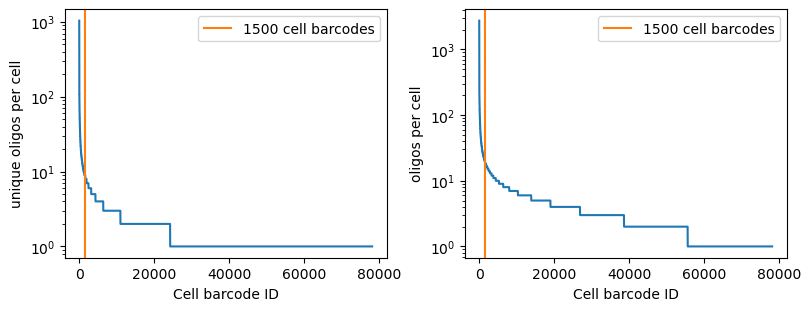

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, sharex=True)
sns.lineplot(
    dist_unique_oligos.sort_values(ascending=False).reset_index(drop=True) \
        .rename('unique oligos per cell').rename_axis('Cell barcode ID').reset_index(),
    x='Cell barcode ID',
    y='unique oligos per cell',
    ax=axs[0])
sns.lineplot(
    dist_oligos.sort_values(ascending=False).reset_index(drop=True) \
        .rename('oligos per cell').rename_axis('Cell barcode ID').reset_index(),
    x='Cell barcode ID',
    y='oligos per cell',
    ax=axs[1])
for ax in axs:
    ax.set_yscale('log')
    ax.axvline(x=1500, c='C1', label='1500 cell barcodes')
    ax.legend()
fig.show()

### Distribution of oligos per cell

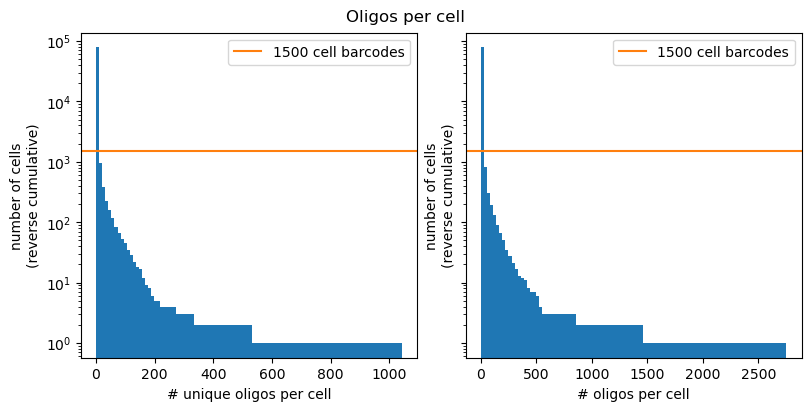

In [179]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharey=True)
axs[0].hist(dist_unique_oligos.values, bins=100, cumulative=-1, log=True)
axs[0].axhline(y=1500, c='C1', label='1500 cell barcodes')
axs[0].legend()
axs[0].set(xlabel='# unique oligos per cell', ylabel='number of cells\n(reverse cumulative)')
axs[1].hist(dist_oligos.values, bins=100, cumulative=-1, log=True)
axs[1].axhline(y=1500, c='C1', label='1500 cell barcodes')
axs[1].legend()
axs[1].set(xlabel='# oligos per cell', ylabel='number of cells\n(reverse cumulative)')
fig.suptitle('Oligos per cell')
fig.show()

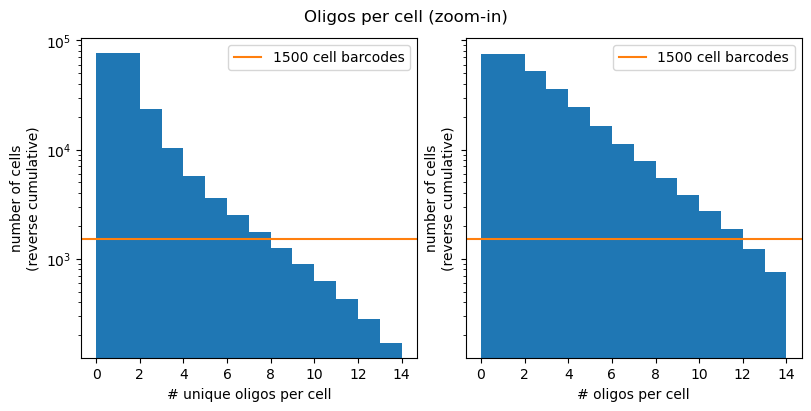

In [178]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharey=True)
axs[0].hist(dist_unique_oligos.values, bins=list(range(15)), cumulative=-1, log=True)
axs[0].axhline(y=1500, c='C1', label='1500 cell barcodes')
axs[0].legend()
axs[0].set(xlabel='# unique oligos per cell', ylabel='number of cells\n(reverse cumulative)')
axs[1].hist(dist_oligos.values, bins=list(range(15)), cumulative=-1, log=True)
axs[1].axhline(y=1500, c='C1', label='1500 cell barcodes')
axs[1].legend()
axs[1].set(xlabel='# oligos per cell', ylabel='number of cells\n(reverse cumulative)')
fig.suptitle('Oligos per cell (zoom-in)')
fig.show()

### Recluster allowing for 1 tag substitution

In [122]:
df_umi_counts = []
for barcode, cell in cells.items():
    for umi, count in cell.items():
        df_umi_counts.append([barcode, umi, count])
df_umi_counts = pd.DataFrame(df_umi_counts, columns=['barcode', 'umi', 'count'])

In [123]:
df_umi_counts['Y'] = df_umi_counts['barcode'].str.extract('\[NYStgBot_(\d+)\]', expand=False).astype(int)
df_umi_counts['R1'] = df_umi_counts['barcode'].str.extract('\[R1Bot_(\d+)\]', expand=False).astype(int)
df_umi_counts['R2'] = df_umi_counts['barcode'].str.extract('\[R2Bot_(\d+)\]', expand=False).astype(int)
df_umi_counts['R3'] = df_umi_counts['barcode'].str.extract('\[R3Bot_(\d+)\]', expand=False).astype(int)
df_oligo_counts_unique = df_umi_counts \
    .groupby(['barcode', 'Y', 'R1', 'R2', 'R3'])['umi'].count() \
    .reset_index().rename(columns={'umi': 'count'}) \
    .sort_values('count', ascending=False)
df_oligo_counts = df_umi_counts \
    .groupby(['barcode', 'Y', 'R1', 'R2', 'R3'])['count'].sum() \
    .reset_index().sort_values('count', ascending=False)

In [124]:
tmp = df_oligo_counts.set_index('barcode').sort_values('count', ascending=False)
df_oligo_counts_clustered = []
while len(tmp) > 0:
    current_barcode = tmp.iloc[0].copy()
    mask_R1 = tmp['R1'] == current_barcode['R1']
    mask_R2 = tmp['R2'] == current_barcode['R2']
    mask_R3 = tmp['R3'] == current_barcode['R3']
    mask_Y = tmp['Y'] == current_barcode['Y']
    mask_cluster = \
        (mask_R1 & mask_R2 & mask_R3) | \
        (mask_R1 & mask_R2 & mask_Y) | \
        (mask_R1 & mask_Y & mask_R3) | \
        (mask_Y & mask_R2 & mask_R3)
    current_barcode['count'] = tmp.loc[mask_cluster, 'count'].sum()
    df_oligo_counts_clustered.append(current_barcode)
    tmp = tmp.loc[~mask_cluster]
df_oligo_counts_clustered = pd.concat(df_oligo_counts_clustered, axis=1).T

In [125]:
tmp = df_oligo_counts_unique.set_index('barcode').sort_values('count', ascending=False)
df_oligo_counts_unique_clustered = []
while len(tmp) > 0:
    current_barcode = tmp.iloc[0].copy()
    mask_R1 = tmp['R1'] == current_barcode['R1']
    mask_R2 = tmp['R2'] == current_barcode['R2']
    mask_R3 = tmp['R3'] == current_barcode['R3']
    mask_Y = tmp['Y'] == current_barcode['Y']
    mask_cluster = \
        (mask_R1 & mask_R2 & mask_R3) | \
        (mask_R1 & mask_R2 & mask_Y) | \
        (mask_R1 & mask_Y & mask_R3) | \
        (mask_Y & mask_R2 & mask_R3)
    current_barcode['count'] = tmp.loc[mask_cluster, 'count'].sum()
    df_oligo_counts_unique_clustered.append(current_barcode)
    tmp = tmp.loc[~mask_cluster]
df_oligo_counts_unique_clustered = pd.concat(df_oligo_counts_unique_clustered, axis=1).T

#### Number of oligos per cell barcode (akin to scSPRITE Figure 1C)

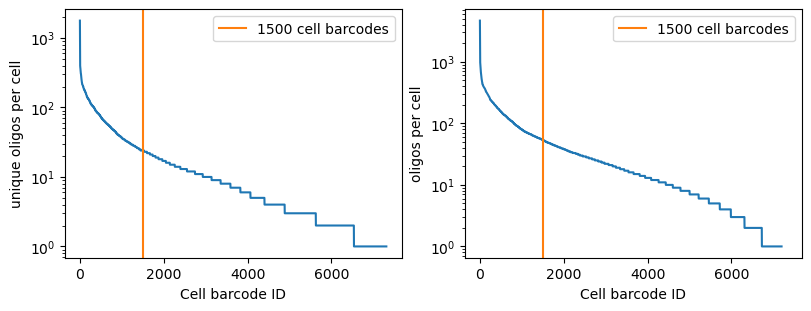

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True, sharex=True)
sns.lineplot(
    df_oligo_counts_unique_clustered['count'].sort_values(ascending=False).reset_index(drop=True) \
        .rename('unique oligos per cell').rename_axis('Cell barcode ID').reset_index(),
    x='Cell barcode ID',
    y='unique oligos per cell',
    ax=axs[0])
sns.lineplot(
    df_oligo_counts_clustered['count'].sort_values(ascending=False).reset_index(drop=True) \
        .rename('oligos per cell').rename_axis('Cell barcode ID').reset_index(),
    x='Cell barcode ID',
    y='oligos per cell',
    ax=axs[1])
for ax in axs:
    ax.set_yscale('log')
    ax.axvline(x=1500, c='C1', label='1500 cell barcodes')
    ax.legend()
fig.show()

#### Distribution of oligos per cell

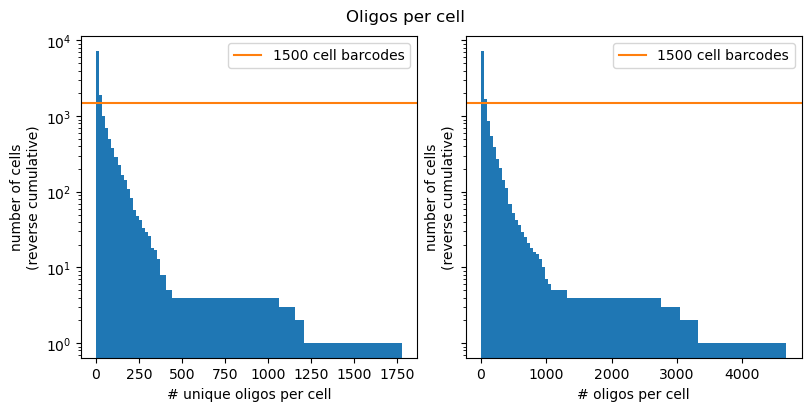

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharey=True)
axs[0].hist(df_oligo_counts_unique_clustered['count'].values, bins=100, cumulative=-1, log=True)
axs[0].axhline(y=1500, c='C1', label='1500 cell barcodes')
axs[0].legend()
axs[0].set(xlabel='# unique oligos per cell', ylabel='number of cells\n(reverse cumulative)')
axs[1].hist(df_oligo_counts_clustered['count'].values, bins=100, cumulative=-1, log=True)
axs[1].axhline(y=1500, c='C1', label='1500 cell barcodes')
axs[1].legend()
axs[1].set(xlabel='# oligos per cell', ylabel='number of cells\n(reverse cumulative)')
fig.suptitle('Oligos per cell')
fig.show()

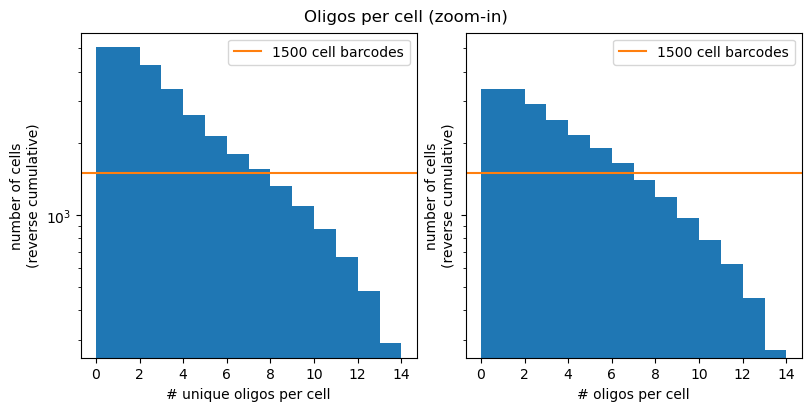

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharey=True)
axs[0].hist(df_oligo_counts_unique_clustered['count'].values, bins=list(range(15)), cumulative=-1, log=True)
axs[0].axhline(y=1500, c='C1', label='1500 cell barcodes')
axs[0].legend()
axs[0].set(xlabel='# unique oligos per cell', ylabel='number of cells\n(reverse cumulative)')
axs[1].hist(df_oligo_counts_clustered['count'].values, bins=list(range(15)), cumulative=-1, log=True)
axs[1].axhline(y=1500, c='C1', label='1500 cell barcodes')
axs[1].legend()
axs[1].set(xlabel='# oligos per cell', ylabel='number of cells\n(reverse cumulative)')
fig.suptitle('Oligos per cell (zoom-in)')
fig.show()

## Cluster barcodes

Unfortunately, because so few read pairs contain both a cell barcode and cluster barcode, this dataset cannot resolve whether there were on-bead collisions where chromatin from 2 cells clustered together.

# Old

## Chromatin reads (old)

How many Read 1 reads start with DPM?
- Trim those reads
  - How many of those trimmed reads have any technical (tag) sequences?
  - Try mapping those reads to DNA

Most R1 reads start with DPMBot

In [23]:
%%bash -s {DIR_DATA} {DIR_READ_STRUCTURE}
DIR_DATA="$1"
DIR_READ_STRUCTURE="$2"

PATH_R1="${DIR_DATA}/20230831_btyeh_HEK_H3K4me3_scChIPseq_aliquot_2_5pct_1_S23_R1_001.fastq.gz"
PATH_CONFIG="${DIR_READ_STRUCTURE}/splitcode-config_R1-DPM.tsv"
PATH_MAPPING="${DIR_READ_STRUCTURE}/mapping_R1-DPM.tsv"
PATH_SUMMARY="${DIR_READ_STRUCTURE}/summary_R1-DPM.json"

splitcode -c "$PATH_CONFIG" \
    --assign --no-output --no-outb -t 4 \
    --mapping="$PATH_MAPPING" \
    --summary="$PATH_SUMMARY" \
    "$PATH_R1"

* Using a list of 48 tags (vector size: 48; map size: 1,968; num elements in map: 1,968)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20230831_HEK_H3K4me3_scChIPseq/20230831_btyeh_HEK_H3K4me3_scChIPseq_aliquot_2_5pct_1_S23_R1_001.fastq.gz
* processing the reads ...
done 
* processed 124,871 reads, 82,466 reads were assigned


Trim R1 reads that start with DPMBot
- Remove the 5' DPMBot tag
- Remove any 3' Illumina adapter

In [24]:
%%bash -s {DIR_DATA} {DIR_READ_STRUCTURE}
DIR_DATA="$1"
DIR_READ_STRUCTURE="$2"

SET="R1-DPM-trim"

PATH_R1="${DIR_DATA}/20230831_btyeh_HEK_H3K4me3_scChIPseq_aliquot_2_5pct_1_S23_R1_001.fastq.gz"
PATH_CONFIG="${DIR_READ_STRUCTURE}/splitcode-config_${SET}.tsv"
PATH_MAPPING="${DIR_READ_STRUCTURE}/mapping_${SET}.tsv"
PATH_SUMMARY="${DIR_READ_STRUCTURE}/summary_${SET}.json"
PATH_OUTPUT="${DIR_READ_STRUCTURE}/out_${SET}.fastq"

splitcode -c "$PATH_CONFIG" \
    --assign --no-outb -t 4 \
    --output "$PATH_OUTPUT" --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
    "$PATH_R1"

* Using a list of 49 tags (vector size: 50; map size: 9,742; num elements in map: 10,126)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20230831_HEK_H3K4me3_scChIPseq/20230831_btyeh_HEK_H3K4me3_scChIPseq_aliquot_2_5pct_1_S23_R1_001.fastq.gz
* processing the reads ...
done 
* processed 124,871 reads, 82,212 reads were assigned


Further trim R1 reads that start with DPMBot (`DPM_bot + DNA + A + DPM + Odd + Even + Odd + Even + Y` --> `DNA`)
- Remove DPMTop and anything 3' of that
- `PATH_OUTPUT` presumably contains short DNA inserts where `DPM_bot + DNA + A + DPM` was <= R1 read length of 100 bp
- `PATH_UNASSIGNED` presumably contains long DNA inserts where `DPM` is not in R1

In [27]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"

CONFIG_NAME="R1-3prime-DPM-trim"

PATH_R1="${DIR_READ_STRUCTURE}/out_R1-DPM-trim.fastq"
PATH_CONFIG="${DIR_READ_STRUCTURE}/splitcode-config_${CONFIG_NAME}.tsv"
PATH_MAPPING="${DIR_READ_STRUCTURE}/mapping_${CONFIG_NAME}.tsv"
PATH_SUMMARY="${DIR_READ_STRUCTURE}/summary_${CONFIG_NAME}.json"
PATH_OUTPUT="${DIR_READ_STRUCTURE}/out_${CONFIG_NAME}.fastq"
PATH_UNASSIGNED="${DIR_READ_STRUCTURE}/unmapped_${CONFIG_NAME}.fastq"

splitcode -c "$PATH_CONFIG" \
    --assign --no-outb --empty-remove --mod-names -t 4 \
    --output="$PATH_OUTPUT" --unassigned="$PATH_UNASSIGNED" --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
    "$PATH_R1"

* Using a list of 49 tags (vector size: 49; map size: 2,165; num elements in map: 2,172)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_aux/20230831_HEK_H3K4me3_scChIPseq/read_structure/out_R1-DPM-trim.fastq
* processing the reads ...
done 
* processed 82,212 reads, 99 reads were assigned


How many of the presumably long DNA insert reads contain any technical (tag) sequences?

In [32]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"

PATH_R1="${DIR_READ_STRUCTURE}/unmapped_R1-3prime-DPM-trim.fastq"
PATH_CONFIG="${DIR_READ_STRUCTURE}/splitcode-config_all-short.tsv"
PATH_MAPPING="${DIR_READ_STRUCTURE}/mapping_R1-3prime-DPM-trim_tags.tsv"
PATH_SUMMARY="${DIR_READ_STRUCTURE}/summary_R1-3prime-DPM-trim_tags.json"
PATH_OUTPUT="${DIR_READ_STRUCTURE}/out_R1-3prime-DPM-trim_tags.fastq"

splitcode -c "$PATH_CONFIG" \
    --assign --no-outb -t 4 --loc-names \
    --output="$PATH_OUTPUT" --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
    "$PATH_R1"

* Using a list of 1008 tags (vector size: 1008; map size: 465,601; num elements in map: 465,693)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_aux/20230831_HEK_H3K4me3_scChIPseq/read_structure/unmapped_R1-3prime-DPM-trim.fastq
* processing the reads ...
done 
* processed 82,104 reads, 79,585 reads were assigned


In [35]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"

PATH_R1="${DIR_READ_STRUCTURE}/test.fastq"
PATH_CONFIG="${DIR_READ_STRUCTURE}/splitcode-config_all-short.tsv"

splitcode -c "$PATH_CONFIG" \
    --assign --no-outb -t 4 --loc-names --mapping /dev/null \
    --pipe "$PATH_R1"

@VH00472:215:AAF3KCVM5:1:1101:52372:1057 LX:Z:DPMTop6_75:0,0-20,NYStgBot_31:0,21-30,EvenTop_31:0,49-73
ATAAATCGGAGATCGGAAGACATGACAAGTCAAACGTCTTCTACTAGGCAGTTGTCAGATCCACACAGCAACACAAGTCAAACGTCTTCTA
+
CCCCCC;CCCCCCCCCCCCCCCCCCCCCC;CCCCCCCCCCCCCCCCCCCCCCCC-CCC;CCCCCCCCCCCCCCCCCCCCCC;CCCCCCCCC


Try mapping those reads to DNA

In [28]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"

source ~/.bashrc
conda activate chipdip

PATH_R1="${DIR_READ_STRUCTURE}/unmapped_R1-3prime-DPM-trim.fastq"
PATH_BOWTIE2_INDEX="/central/groups/guttman/genomes/homo_sapiens/hg38/GRCh38_noalt_as/GRCh38_noalt_as"
PATH_OUT="${DIR_READ_STRUCTURE}/R1.sam"

bowtie2 \
    -p 10 \
    -t \
    --phred33 \
    -S "$PATH_OUT" \
    -x "$PATH_BOWTIE2_INDEX" \
    -U "$PATH_R1"

Time loading reference: 00:00:00
Time loading forward index: 00:00:01
Time loading mirror index: 00:00:01
Multiseed full-index search: 00:00:01
82104 reads; of these:
  82104 (100.00%) were unpaired; of these:
    79172 (96.43%) aligned 0 times
    1401 (1.71%) aligned exactly 1 time
    1531 (1.86%) aligned >1 times
3.57% overall alignment rate
Time searching: 00:00:03
Overall time: 00:00:03


In [29]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"

source ~/.bashrc
conda activate chipdip

PATH_R1="${DIR_READ_STRUCTURE}/out_R1-3prime-DPM-trim.fastq"
PATH_BOWTIE2_INDEX="/central/groups/guttman/genomes/homo_sapiens/hg38/GRCh38_noalt_as/GRCh38_noalt_as"
PATH_OUT="${DIR_READ_STRUCTURE}/R1_short_insert.sam"

bowtie2 \
    -p 10 \
    -t \
    --phred33 \
    -S "$PATH_OUT" \
    -x "$PATH_BOWTIE2_INDEX" \
    -U "$PATH_R1"

Time loading reference: 00:00:00
Time loading forward index: 00:00:01
Time loading mirror index: 00:00:01
Multiseed full-index search: 00:00:00
81 reads; of these:
  81 (100.00%) were unpaired; of these:
    35 (43.21%) aligned 0 times
    22 (27.16%) aligned exactly 1 time
    24 (29.63%) aligned >1 times
56.79% overall alignment rate
Time searching: 00:00:02
Overall time: 00:00:02


In [ ]:
# %%bash -s {DIR_DATA} {DIR_READ_STRUCTURE}
# DIR_DATA="$1"
# DIR_READ_STRUCTURE="$2"

# PATH_R1="${DIR_DATA}/20230831_btyeh_HEK_H3K4me3_scChIPseq_aliquot_2_5pct_1_S23_R1_001.fastq.gz"
# PATH_CONFIG="${DIR_READ_STRUCTURE}/splitcode_config-all_short_collapsed.tsv"
# PATH_MAPPING="${DIR_READ_STRUCTURE}/mapping_R1-all_short_collapsed.tsv"
# PATH_SUMMARY="${DIR_READ_STRUCTURE}/summary_R1-all_short_collapsed.json"
# PATH_OUTPUT="${DIR_READ_STRUCTURE}/out_R1-all_short_collapsed.fastq"

# splitcode -c "$PATH_CONFIG" \
#     --assign --no-outb --loc-names -t 4 \
#     --output="$PATH_OUTPUT" --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
#     "$PATH_R1"

In [227]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_OUTPUT="${DIR_READ_STRUCTURE}/out_R1-all_short_collapsed.fastq"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R1-all_short_collapsed.tsv"

grep -o -E -e "LX:Z:(([^:]+:0,[0-9]+-[0-9]+),?)+" "$PATH_OUTPUT" | 
    sed -e "s/LX:Z://" -e "s/:0,/:/g" -e "s/,$//" |
    sort |
    uniq -c |
    sort -n -r -k1 |
    sed -E -e "s/^\s+//" -e "s/\s+/\t/" > "$PATH_MAPPING_LOC"

In [228]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R1-all_short_collapsed.tsv"
head "$PATH_MAPPING_LOC"

38284	DPMBot:0-9,DPMTop:10-30,OddTop:35-59,EvenTop:59-83
5916	DPMBot:0-9,DPMTop:10-30,OddTop:35-59,EvenTop:59-83,NYLigEvenStgTop:83-100
5591	oligo_rc:0-10,R1Top:18-41,R2Top:41-64,R3Top:64-87
5562	oligo_rc:0-9,R1Top:17-40,R2Top:40-63,R3Top:63-86
5548	DPMBot:0-9,EvenTop:26-50,OddTop:50-74,EvenTop:74-98
4471	oligo_rc:0-9,OddTop:17-41,EvenTop:41-65,OddTop:65-89
4091	DPMBot:0-9,DPMTop:10-30,OddTop:35-59,EvenTop:59-83,NYLigEvenStgTop:83-99
2415	DPMBot:0-9,NYLigEvenStgTop:26-43,adapter:43-56
2305	DPMBot:0-9,DPMTop:10-30,NYLigEvenStgTop:35-52,adapter:52-65
2261	DPMBot:0-9


Collapse by tag order (ignore exact locations)

In [236]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R1-all_short_collapsed.tsv"
PATH_MAPPING_R1="${DIR_READ_STRUCTURE}/mapping_R1-all_short_collapsed.tsv"
sed -E -e 's/:[0-9]+-[0-9]+//g' "$PATH_MAPPING_LOC" |
    awk -F'\t' -v OFS='\t' '{key = $2; value = $1; sum[key] += value} END {for (key in sum) {print sum[key], key}}' |
    sort -n -r -k 1 > "$PATH_MAPPING_R1"

In [237]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_R1="${DIR_READ_STRUCTURE}/mapping_R1-all_short_collapsed.tsv"
head "$PATH_MAPPING_R1"

39550	DPMBot,DPMTop,OddTop,EvenTop
11994	oligo_rc,R1Top,R2Top,R3Top
10279	DPMBot,DPMTop,OddTop,EvenTop,NYLigEvenStgTop
7195	oligo_rc,OddTop,EvenTop,OddTop
5837	DPMBot,EvenTop,OddTop,EvenTop
4681	DPMBot,NYLigEvenStgTop,adapter
4549	DPMBot,DPMTop,NYLigEvenStgTop,adapter
3874	DPMBot,EvenTop,NYLigEvenStgTop,adapter
3771	DPMBot,OddTop,EvenTop,NYLigEvenStgTop
2274	DPMBot


Starting tag counts

In [229]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R1-all_short_collapsed.tsv"
sed -E -e "s/,.*//" "$PATH_MAPPING_LOC" |
    awk -F'\t' -v OFS='\t' '{key = $2; value = $1; sum[key] += value} END {for (key in sum) {print key, sum[key]}}' |
    sort -n -r -k 2 |
    head -n 10 | column -t -s $'\t'

DPMBot:0-9     83026
oligo_rc:0-9   17544
oligo_rc:0-10  14376
DPMTop:9-29    640
DPMTop:3-23    517
OddTop:25-49   420
NYStgBot:0-10  385
DPMTop:1-21    370
DPMTop:10-30   345
DPMTop:2-22    333


In [ ]:
# %%bash -s {DIR_DATA} {DIR_READ_STRUCTURE}
# DIR_DATA="$1"
# DIR_READ_STRUCTURE="$2"

# PATH_R2="${DIR_DATA}/20230831_btyeh_HEK_H3K4me3_scChIPseq_aliquot_2_5pct_1_S23_R2_001.fastq.gz"
# PATH_CONFIG="${DIR_READ_STRUCTURE}/splitcode_config-all_short_collapsed.tsv"
# PATH_MAPPING="${DIR_READ_STRUCTURE}/mapping_R2-all_short_collapsed.tsv"
# PATH_SUMMARY="${DIR_READ_STRUCTURE}/summary_R2-all_short_collapsed.json"
# PATH_OUTPUT="${DIR_READ_STRUCTURE}/out_R2-all_short_collapsed.fastq"

# splitcode -c "$PATH_CONFIG" \
#     --assign --no-outb --loc-names -t 4 \
#     --output="$PATH_OUTPUT" --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
#     "$PATH_R2"

In [240]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_OUTPUT="${DIR_READ_STRUCTURE}/out_R2-all_short_collapsed.fastq"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R2-all_short_collapsed.tsv"

grep -o -E -e "(([^:,]+:1,[0-9]+-[0-9]+),?)+" "$PATH_OUTPUT" | 
    sed -e "s/:1,/:/g" -e "s/,$//" |
    sort |
    uniq -c |
    sort -n -r -k1 |
    sed -E -e "s/^\s+//" -e "s/\s+/\t/" > "$PATH_MAPPING_LOC"

In [241]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R2-all_short_collapsed.tsv"
head "$PATH_MAPPING_LOC"

10979	NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,EvenBot:58-82,OddBot:82-106,DPMBot:129-138,DPMTop:139-159
8325	NYStgBot:0-9,EvenBot:9-33,OddBot:33-57,EvenBot:57-81,OddBot:81-105,DPMBot:128-137,DPMTop:138-158
4105	NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,DPMBot:81-90,DPMTop:91-111
2961	NYStgBot:0-9,EvenBot:9-33,OddBot:33-57,DPMBot:80-89,DPMTop:90-110
2016	NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,EvenBot:58-82,OddBot:82-106,DPMTop:106-126
1993	NYStgBot:0-10,EvenBot:10-34,DPMTop:34-54
1823	NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,EvenBot:58-82,OddBot:83-106,DPMBot:129-138,DPMTop:139-159
1794	NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,EvenBot:58-82,DPMTop:82-102
1709	NYStgBot:0-10,DPMBot:33-42,DPMTop:43-63
1595	NYStgBot:0-10,EvenBot:10-34,OddBot:34-58,EvenBot:58-82,OddBot:82-106,DPMBot:129-138,DPMTop:139-159,DPMBot:176-185


Collapse by tag order (ignore exact locations)

In [243]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R2-all_short_collapsed.tsv"
PATH_MAPPING_R2="${DIR_READ_STRUCTURE}/mapping_R2-all_short_collapsed.tsv"
sed -E -e 's/:[0-9]+-[0-9]+//g' "$PATH_MAPPING_LOC" |
    awk -F'\t' -v OFS='\t' '{key = $2; value = $1; sum[key] += value} END {for (key in sum) {print sum[key], key}}' |
    sort -n -r -k 1 > "$PATH_MAPPING_R2"

In [244]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_R2="${DIR_READ_STRUCTURE}/mapping_R2-all_short_collapsed.tsv"
head "$PATH_MAPPING_R2"

24030	NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot,DPMTop
8327	NYStgBot,EvenBot,OddBot,DPMBot,DPMTop
6091	NYStgBot,R3Bot,R2Bot,R1Bot,oligo
5246	NYStgBot,EvenBot,OddBot,EvenBot,OddBot,oligo
5166	NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot,DPMTop,DPMBot
4953	NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMTop
3925	NYStgBot,EvenBot,DPMTop
3772	NYStgBot,EvenBot,OddBot,EvenBot,DPMTop
3513	NYStgBot,EvenBot,OddBot,DPMTop
3495	NYStgBot,DPMBot,DPMTop


Starting tag counts

In [242]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R2-all_short_collapsed.tsv"
sed -E -e "s/,.*//" "$PATH_MAPPING_LOC" |
    awk -F'\t' -v OFS='\t' '{key = $2; value = $1; sum[key] += value} END {for (key in sum) {print key, sum[key]}}' |
    sort -n -r -k 2 |
    head -n 10 | column -t -s $'\t'

NYStgBot:0-10  65409
NYStgBot:0-9   52780
NYStgBot:0-12  1367
EvenBot:9-33   731
EvenBot:10-34  727
oligo_rc:0-9   622
oligo_rc:0-10  437
NYStgBot:0-11  368
R3Bot:9-32     103
EvenBot:8-32   102


In [130]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R1-all_short_collapsed.tsv"
echo "Number of sequences with oligo in forward orientation:"
grep "oligo:" "$PATH_MAPPING_LOC" | wc -l

Number of sequences with oligo in forward orientation:
0


In [131]:
%%bash -s {DIR_READ_STRUCTURE}
DIR_READ_STRUCTURE="$1"
PATH_MAPPING_LOC="${DIR_READ_STRUCTURE}/mapping-loc_R1-all_short_collapsed.tsv"
echo "Number of sequences with oligo_rc not at the start of the read:"
grep -E -e ",oligo_rc" -e "oligo_rc:[^0]+-" "$PATH_MAPPING_LOC" |
    cut -f 1 -d ' ' |
    awk '{n = n + $1} END {print n}'

Number of sequences with oligo_rc not at the start of the read:
207


In [132]:
path_mapping_loc = os.path.join(DIR_READ_STRUCTURE, 'mapping-loc_R1-all_short_collapsed.tsv')
path_mapping = os.path.join(DIR_READ_STRUCTURE, 'mapping_R1-all_short_collapsed.tsv')
df_collapsed = pd.read_csv(path_mapping, sep='\t', header=None, names=['final barcode', 'pattern', 'count']) \
    .drop(columns='final barcode') \
    .sort_values('count', ascending=False)
df_collapsed_loc = pd.read_csv(path_mapping_loc, sep='\t', header=None, names=['count', 'pattern'])

#### Cell Barcode Ligation Efficiency

How many oligos were ligated with cell barcode (R1-R3), versus only a cluster barcode (odd, even, etc.)?

In [133]:
print('Most oligos were ligated with R1Top:')
print(f'{16729 / 31920:.1%} oligos ligated with R1Top')
print(f'- {12221 / 31920:.1%} oligos ligated with R1Top, R2Top, and R3Top')
print(f'{10223 / 31920:.1%} oligos ligated with OddTop')
print(f'- {7210 / 31920:.1%} oligos ligated with OddTop, EvenTop, OddTop')

Most oligos were ligated with R1Top:
52.4% oligos ligated with R1Top
- 38.3% oligos ligated with R1Top, R2Top, and R3Top
32.0% oligos ligated with OddTop
- 22.6% oligos ligated with OddTop, EvenTop, OddTop


In [134]:
print('Total number of reads starting with oligo_rc:')
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.startswith('oligo_rc:0'), 'count'].sum()

Total number of reads starting with oligo_rc:


31920

In [135]:
print('Oligos ligated with R1Top:')
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.contains('^oligo_rc:0-\d+,R1Top'), 'count'].sum()

Oligos ligated with R1Top:


16729

In [206]:
print('Oligos ligated with R1Top, R2Top, and R3Top:')
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.contains(
    '^oligo_rc:0-\d+,R1Top:\d+-\d+,R2Top:\d+-\d+,R3Top:\d+-\d+'), 'count'].sum()

Oligos ligated with R1Top, R2Top, and R3Top:


12221

In [137]:
print('Oligos ligated with OddTop:')
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.contains(
    '^oligo_rc:0-\d+,OddTop'), 'count'].sum()

Oligos ligated with OddTop:


10080

In [138]:
print('Oligos ligated with OddTop, EvenTop, OddTop:')
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.contains(
    '^oligo_rc:0-\d+,OddTop:\d+-\d+,EvenTop:\d+-\d+,OddTop:\d+-\d+'), 'count'].sum()

Oligos ligated with OddTop, EvenTop, OddTop:


7191

In [139]:
print('Unligated oligos:')
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.contains('^oligo_rc:0-\d+$'), 'count'].sum()

Unligated oligos:


34

Most oligos ligated with neither R1Top or OddTop were ligated by NYLigEvenStgTop

In [140]:
print('Oligos ligated with neither R1Top nor OddTop:')
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.contains(
    '^oligo_rc:0-\d+,(?!OddTop|R1Top)'), 'count'].sum()

Oligos ligated with neither R1Top nor OddTop:


5077

In [141]:
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.contains('^oligo_rc:0-\d+,(?!OddTop|R1Top)')].head(10)

,count,pattern
30,246,"oligo_rc:0-9,NYLigEvenStgTop:17-34,adapter:34-47"
37,198,"oligo_rc:0-9,NYLigEvenStgTop:17-33,adapter:33-46"
57,137,"oligo_rc:0-10,NYLigEvenStgTop:18-35,adapter:35-48"
58,133,"oligo_rc:0-9,EvenTop:36-60,OddTop:60-84"
64,117,"oligo_rc:0-10,NYLigEvenStgTop:18-34,adapter:34-47"
67,115,"oligo_rc:0-9,DPMTop:25-45,OddTop:50-74,EvenTop..."
71,111,"oligo_rc:0-10,EvenTop:37-61,OddTop:61-85"
80,89,"oligo_rc:0-10,DPMTop:26-46,OddTop:51-75,EvenTo..."
120,56,"oligo_rc:0-9,EvenTop:26-50,OddTop:50-74,EvenTo..."
125,54,"oligo_rc:0-9,EvenTop:27-51,OddTop:51-75,EvenTo..."


In [142]:
df_collapsed.loc[df_collapsed['pattern'].str.contains('^oligo_rc,(?!OddTop|R1Top)')].head(8)

,pattern,count
16,"oligo_rc,NYLigEvenStgTop,adapter",1267
5,"oligo_rc,EvenTop,OddTop",949
47,"oligo_rc,DPMTop,OddTop,EvenTop",688
26,"oligo_rc,EvenTop,NYLigEvenStgTop,adapter",554
46,"oligo_rc,EvenTop,OddTop,EvenTop",399
90,"oligo_rc,EvenTop",175
93,"oligo_rc,adapter",161
74,"oligo_rc,DPMTop,OddTop",106


All oligo sequences are essentially only present in reverse complement orientation at the start of R1. (This can be checked 

In [56]:
print('Number of reads with forward orientation oligo:',
      df.loc[df['pattern_loc_group_R1'].str.contains('Oligo:') | df['pattern_loc_group_R2'].str.contains('OligoRC:'), 'count'].sum())

Number of reads with forward orientation oligo: 1269


In [61]:
print('Number of reads with reverse orientation oligo not at the start of R1:',
      df_R1_tagged.loc[df_R1_tagged['pattern_loc_group_R1'].str.contains(',OligoRC:') | df_R1_tagged['pattern_order_group_R2'].str.contains('Oligo,'), 'count'].sum())

Number of reads with reverse orientation oligo not at the start of R1: 2286


In [220]:
regex_oligo_cell = re.compile('oligo_rc:0,0-\d+,R1Top:0,\d+-\d+,R2Top:0,\d+-\d+,R3Top:0,\d+-\d+')
regex_oligo_cluster = re.compile('oligo_rc:0,0-\d+,OddTop:0,\d+-\d+,EvenTop:0,\d+-\d+,OddTop:0,\d+-\d+')

In [252]:
df_collapsed_loc.loc[df_collapsed_loc['pattern'].str.contains('oligo_rc:0,0-\d+,R1Top:0,\d+-\d+,R2Top:0,\d+-\d+,R3Top:0,\d+-\d+')]

,count,pattern
15,1452,"oligo_rc:0,0-10,R1Top:0,18-41,R2Top:0,41-64,R3..."
19,1225,"oligo_rc:0,0-9,R1Top:0,17-40,R2Top:0,40-63,R3T..."
22,1134,"oligo_rc:0,0-9,R1Top:0,17-40,R2Top:0,40-63,R3T..."
25,951,"oligo_rc:0,0-10,R1Top:0,18-41,R2Top:0,41-64,R3..."
28,626,"oligo_rc:0,0-9,R1Top:0,17-40,R2Top:0,40-63,R3T..."
...,...,...
10022,1,"oligo_rc:0,0-10,R1Top:0,17-40,R2Top:0,40-63,R3..."
10023,1,"oligo_rc:0,0-10,R1Top:0,17-40,R2Top:0,40-63,R3..."
10024,1,"oligo_rc:0,0-10,R1Top:0,17-40,R2Top:0,40-63,R3..."
10025,1,"oligo_rc:0,0-10,R1Top:0,17-40,R2Top:0,40-62,R3..."


In [221]:
oligo_spritezero_R2_barcode_loc_counts = collections.defaultdict(int)
oligo_spritezero_R2_barcode_counts = collections.defaultdict(int)
oligo_cluster_R2_barcode_loc_counts = collections.defaultdict(int)
oligo_cluster_R2_barcode_counts = collections.defaultdict(int)

In [222]:
path_r1_annotated = os.path.join(DIR_READ_STRUCTURE, 'out_R1-all_short_collapsed.fastq')
path_r2_annotated = os.path.join(DIR_READ_STRUCTURE, 'out_R2-all_short_collapsed.fastq')
with file_open(path_r1_annotated) as read_1, \
     file_open(path_r2_annotated) as read_2:
    for ((qname1, seq1, _, _), (qname2, seq2, _, _)) in zip(fastq_parse(read_1), fastq_parse(read_2)):
        barcode_r2_loc = re.sub(':0,', ':', qname2.split('LX:Z:')[1])
        barcode_r2 = re.sub(':\d+-\d+', '', barcode_r2_loc)
        if regex_oligo_spritezero.search(qname1):
            oligo_spritezero_R2_barcode_loc_counts[barcode_r2_loc] += 1
            oligo_spritezero_R2_barcode_counts[barcode_r2] += 1
        elif regex_oligo_cluster.search(qname1):
            oligo_cluster_R2_barcode_loc_counts[barcode_r2_loc] += 1
            oligo_cluster_R2_barcode_counts[barcode_r2] += 1

In [212]:
oligo_spritezero_R2_barcode_counts = pd.Series(oligo_spritezero_R2_barcode_counts).sort_values(ascending=False)
print(oligo_spritezero_R2_barcode_counts.sum())
oligo_spritezero_R2_barcode_counts.head(10)

12185


NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot,DPMTop           2314
NYStgBot,EvenBot,OddBot,DPMBot,DPMTop                           817
NYStgBot,R3Bot,R2Bot,R1Bot,oligo                                603
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMTop                   498
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,oligo                    496
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot,DPMTop,DPMBot     496
NYStgBot,EvenBot,DPMTop                                         371
NYStgBot,EvenBot,OddBot,DPMTop                                  366
NYStgBot,EvenBot,OddBot,EvenBot,DPMTop                          358
NYStgBot,DPMBot,DPMTop                                          320
dtype: int64

In [223]:
oligo_cluster_R2_barcode_counts = pd.Series(oligo_cluster_R2_barcode_counts).sort_values(ascending=False)
print(oligo_cluster_R2_barcode_counts.sum())
oligo_cluster_R2_barcode_counts.head(10)

7169


NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot,DPMTop           1345
NYStgBot,EvenBot,OddBot,DPMBot,DPMTop                           469
NYStgBot,R3Bot,R2Bot,R1Bot,oligo                                376
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,oligo                    330
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMBot,DPMTop,DPMBot     305
NYStgBot,EvenBot,OddBot,EvenBot,OddBot,DPMTop                   298
NYStgBot,EvenBot,DPMTop                                         251
NYStgBot,DPMBot,DPMTop                                          215
NYStgBot,EvenBot,OddBot,DPMTop                                  211
NYStgBot,EvenBot,OddBot,EvenBot,DPMTop                          210
dtype: int64

DPMBot is essentially only present at the start of R1

In [134]:
print('Number of R1 reads with 5\' DPMBot and an internal DPMBot:')
df_R1_tagged.loc[df_R1_tagged['pattern_order_group_R1'].str.contains('^DPMBot.*DPMBot'), 'count'].sum()

Number of R1 reads with 5' DPMBot and an internal DPMBot:


230

In [135]:
# negative lookahead assertion
print('Number of R1 reads with no 5\' DPMBot but an internal DPMBot:')
df_R1_tagged.loc[df_R1_tagged['pattern_order_group_R1'].str.contains('^(?!DPMBot).*DPMBot'), 'count'].sum()

Number of R1 reads with no 5' DPMBot but an internal DPMBot:


28

### Merge Read 1 and Read2 via NGMerge

In [ ]:
# Options
# -d: check for dovetailing
# -e: minimum overlap of dovetailed alignments
# -m: minimum overlap of the paired-end reads
# -z: gzip output
cmd_merge = (
    'NGmerge -1 {path_read1} -2 {path_read2} -o {path_merged} -f {path_failed}'
    ' -d -m 30 -e 50 -z'
    ' -l {path_log_stich}'
    ' -c {path_log_dovetail}'
    ' -j {path_log_alignment}'
    ' -n {n_threads}')

In [16]:
dir_merged = os.path.join(DIR_PROC, 'merged')
os.makedirs(dir_merged, exist_ok=True)

In [17]:
n_threads = 10
for sample, group in df_data.groupby('sample'):
    path_merged = os.path.join(dir_merged, f'{sample}.fastq.gz')
    if not os.path.exists(path_merged):
        path_read1 = os.path.join(DIR_DATA, group.loc[group['read'] == 1, 'filename'].item())
        path_read2 = os.path.join(DIR_DATA, group.loc[group['read'] == 2, 'filename'].item())
        path_failed = os.path.join(dir_merged, f'{sample}_failed')
        path_log_stich = os.path.join(dir_merged, f'{sample}.stitch.log')
        path_log_dovetail = os.path.join(dir_merged, f'{sample}.dovetail.log')
        path_log_alignment = os.path.join(dir_merged, f'{sample}.alignment.log')
        cmd_run = cmd_merge.format(
            path_read1=path_read1,
            path_read2=path_read2,
            path_merged=path_merged,
            path_failed=path_failed,
            path_log_stich=path_log_stich,
            path_log_dovetail=path_log_dovetail,
            path_log_alignment=path_log_alignment,
            n_threads=n_threads)
        subprocess.run(cmd_run, shell=True)

Run FASTQC on merged FASTQ files

In [18]:
paths_fastq_merged = []
for sample in df_data['sample'].unique():
    path_merged_fastqc = os.path.join(dir_merged, f'{sample}_fastqc.html')
    if not os.path.exists(path_merged_fastqc):
        paths_fastq_merged.append(os.path.join(dir_merged, f'{sample}.fastq.gz'))
if len(paths_fastq_merged) > 0:
    paths_fastq_merged = ' '.join((f'"{s}"' for s in paths_fastq_merged))
    sprite_env.run(f'fastqc {paths_fastq_merged} -o {dir_merged} -t {n_threads}')

In [13]:
dir_clusters = os.path.join(DIR_PROC, 'clusters')
os.makedirs(dir_clusters, exist_ok=True)

In [14]:
regex_readname = re.compile('::\[[^\]]+\]\[odd\](' + 4 * '\[[^\]]+\]' + ') RX:Z:([ATCG]+)')

In [17]:
all_clusters = dict()
for sample in df_data['sample'].unique():
    print(sample)
    path_barcoded = os.path.join(dir_barcodes, f'{sample}.fastq.gz')
    path_clusters = os.path.join(dir_clusters, f'{sample}.json')
    if not os.path.exists(path_clusters) or True:
        clusters = dict()
        with gzip.open(path_barcoded) as f:
            for (name, seq, _, qual) in tqdm(fastq_parse(f)):
                match = regex_readname.search(name.strip())
                if match:
                    barcode, umi = match.groups()
                    if barcode not in clusters:
                        clusters[barcode] = collections.defaultdict(int)
                    clusters[barcode][umi] += 1
        with open(path_clusters, 'wt') as f:
            json.dump(clusters, f)
    else:
        with open(path_clusters, 'rt') as f:
            clusters = json.load(f)
    all_clusters[sample] = clusters

0-15625cell_aliquot1_150bp


0it [00:00, ?it/s]

0-5cell_aliquotA6_barcode


0it [00:00, ?it/s]

0-5cell_aliquotE9_barcode


0it [00:00, ?it/s]

0-625cell_aliquot3_barcode


0it [00:00, ?it/s]

10cell_aliquot1_barcode


0it [00:00, ?it/s]

In [56]:
path_mapping = os.path.join(DIR_READ_STRUCTURE, 'mapping_R1-all_short.tsv')
df_mapping_R1 = pd.read_csv(path_mapping, sep='\t', header=None, names=['final barcode', 'pattern', 'count']) \
    .drop(columns='final barcode') \
    .sort_values('count', ascending=False)

In [73]:
df_mapping_R1['pattern'].str.split(',').map(lambda x: x[0]).value_counts().sort_values(ascending=False).head(10)

pattern
oligo_bc4_rc    4033
oligo_bc5_rc    3034
oligo_bc3_rc    2897
DPMBot6_22      2750
oligo_bc2_rc    2623
DPMBot6_18      2508
DPMBot6_21      1757
DPMBot6_14      1579
DPMBot6_1       1557
DPMBot6_44      1032
Name: count, dtype: int64

In [65]:
df_mapping_R1.loc[df_mapping_R1['pattern'].str.contains('oligo_bc[2-5]_rc,R1Top[^,]+,R2Top[^,]+,R3Top[^,]+')].sort_values('count', ascending=False).head(20)

,pattern,count
1200,"oligo_bc4_rc,R1TopA4,R2TopB19,R3TopC5",49
5316,"oligo_bc5_rc,R1TopA4,R2TopB19,R3TopC5",35
2673,"oligo_bc2_rc,R1TopA4,R2TopB19,R3TopC5",32
1800,"oligo_bc5_rc,R1TopA2,R2TopB4,R3TopC8",32
8322,"oligo_bc4_rc,R1TopA2,R2TopB4,R3TopC8",27
2150,"oligo_bc3_rc,R1TopA4,R2TopB19,R3TopC5",26
3220,"oligo_bc2_rc,R1TopA5,R2TopB15,R3TopC3",22
4853,"oligo_bc5_rc,R1TopA18,R2TopB3,R3TopC19",20
7761,"oligo_bc2_rc,R1TopA18,R2TopB3,R3TopC19",18
2820,"oligo_bc2_rc,R1TopA2,R2TopB4,R3TopC8",18


<Axes: >

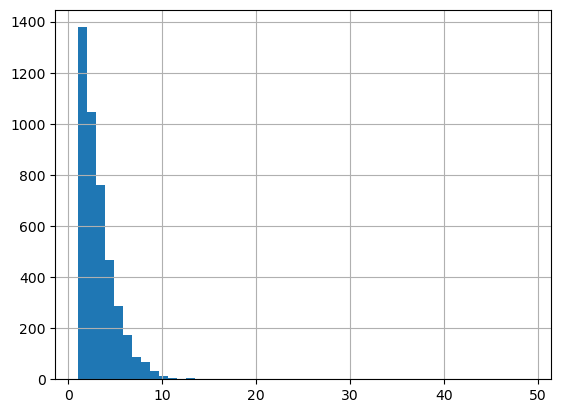

In [64]:
df_mapping_R1.loc[df_mapping_R1['pattern'].str.contains('oligo_bc[2-5]_rc,R1Top[^,]+,R2Top[^,]+,R3Top[^,]+')]